# Classifying spectra using a *Convolutional Neural Network* (CNN) 

1. **Defining the input parameters**
2. **Loading the training and testing data set**
3. **Setting up the architecture for neural network**
4. **Train the network** <br>
    4.1 **Plot the loss and accuracy curve for CNN**
5. **Evaluate the result on the testing data set**

**Data**: 02nd Dec 2019<br>
**Author**: Soumya Shreeram<br>
**Guidance from**: Schäfer Christoph E. Rerné<br>
**Script adapted from**: S. Ben Nejma

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from sklearn.metrics import confusion_matrix
import pickle
import os

Loading the machine learning packages `tensorflow` and `keras`.

In [19]:
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import (Dense, Conv1D, MaxPooling1D, AveragePooling1D,
                          Dropout, Flatten, BatchNormalization)
from keras import optimizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint

## 1. Defining the input parameters 

In [12]:
# code parameters used further
epochs = 100
batch_size = 40 
verbrose = 2    # degree of info. outputted during training
learning_rate=0.001

# directory to save model
save_model_dir = 'Algos/NN_folder/CNN'

# do you want to reuse a previously trained model?
reuse = False

## 2. Loading the training and testing data sets

In [49]:
def loadTrainingTestingData(data_names):
    X_train = np.load("Data_files/"+data_names[0]+".npy", mmap_mode='r')
    Y_train = np.load("Data_files/"+data_names[1]+".npy", mmap_mode='r')
    X_test = np.load("Data_files/"+data_names[2]+".npy", mmap_mode='r')
    Y_test = np.load("Data_files/"+data_names[3]+".npy", mmap_mode='r')
    return X_train, Y_train, X_test, Y_test

def processTrainTestSets(data_sets):
    """
    Function 1) Converts the Y-vectors of intergers to a binary matrix
             2) Reshapes the X-vectors to 1 channel samples
    """
    # converts the vectors of intergers to a binary matrix
    Y_train = keras.utils.to_categorical(data_sets[1])
    Y_test = keras.utils.to_categorical(data_sets[3])

    # reshaping the X-vectors
    train_shape = (data_sets[0].shape[0], data_sets[0].shape[1], 1)
    test_shape = (data_sets[2].shape[0], data_sets[2].shape[1], 1)
    
    X_train = data_sets[0].reshape(train_shape)
    X_test = data_sets[2].reshape(test_shape)
    return X_train, Y_train, X_test, Y_test

In [91]:
# reading the data
data_names = ['X_train', 'Y_train', 'X_test', 'Y_test']

X_train, Y_train, X_test, Y_test = loadTrainingTestingData(data_names)
data_sets = [X_train, Y_train, X_test, Y_test]

# converting Y-vectors to a binary matrix and reshaping the X-vectors
X_train, Y_train, X_test, Y_test = processTrainTestSets(data_sets)

# print shape of training and testing data sets
for i in range(len(data_names)):
               print(data_names[i],'=', np.shape(data_sets[i]))

X_train = (7033, 4317)
Y_train = (7033,)
X_test = (3015, 4317)
Y_test = (3015,)


## 3. Setting up the architecture for the neural network

<img src="Images/Convolutional_neural_network.jpg" alt="FCNN" width="650"/> <br>
Figure shows the typical architecture of a convolutional neural network. <br> <br>

Training the data set implies that we are trying to optimize the loss function. 

* *Optimizer*: The optimizer chosen here is the Stochastic gradient descent optimizer (SGD); the list of other optimizers can be found [here](https://keras.io/optimizers/). 

* *Loss function*: Here, 'Cross entropy' is a method to define this loss function. 

In [16]:
def reuseModel(save_model_dir):
    """
    Function loads a previously trained model
    """
    with open(save_model_dir+'_history.pkl', 'rb') as filehandler:
            history = pickle.load(filehandler)
    return load_model(save_model_dir+'.h5')

In [29]:
if reuse:
    model = reuseModel(save_model_dir)
else:    
    # model architecture
    model = Sequential()
    model.add(AveragePooling1D(pool_size=5))
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # optimizer 
    sgd = optimizers.SGD(lr=learning_rate, momentum=0.5, nesterov=False)

    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    call_back = ModelCheckpoint('Algos/NN_folder/weights.{epoch:02d}'
                                '-{val_loss:.2f}.h5',
                                monitor='val_loss')

## 4. Train the network

The **`model.fit()`** fits the model to the data for the desired number of **`epochs`** (a pass through the entire training set), **`batch_size`** (number of training sample propogated at once through the network), and **`verbrose`** (degree of information printed out while training). 

In [ ]:
model_history = model.fit(X_train, Y_train,
                                  epochs=epochs, batch_size=batch_size,
                                  validation_data=(X_test, Y_test),
                                  verbose=verbrose)

### 4.1 Plot of the loss and accuracy curve for NN1

In [134]:
def setLabels(ax, xlabel, ylabel, ticks):
    """
    Function sets the axes labels, legent size, and ticks
    """
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.legend(loc='center right', fontsize=18)
    ax.grid()
    if ticks:
        ax.tick_params(which='both', labelsize=18)
    return

def plotLoss(ax, loss_Accuracy, labels):
    """
    Function plots the loss curve for training run of x epochs
    """
    ax.plot(history[loss_Accuracy[0]], '#00a15b', lw=2, label=labels[0])
    ax.plot(history[loss_Accuracy[1]], '#fc5400', lw=2, label=labels[1])
    ax.set_title('Loss curve for CNN\n')
    setLabels(ax, 'Epoch', r'$\mathcal{L}\ \equiv$ Categorical cross entropy', ticks=True)
    return

def plotAccuracy(ax, loss_Accuracy, labels):
    """
    Function plots the accuracy curve for training run of x epochs
    """
    ax.plot(history[loss_Accuracy[2]],  '#00a15b', lw=2, label=labels[0])
    ax.plot(history[loss_Accuracy[3]], '#fc5400', lw=2, label=labels[1])
    ax.set_title('Accuracy curve for CNN\n')
    setLabels(ax, 'Epoch', 'Accuracy (%)', ticks=True)
    return

The loss and accuracy curves are plotted for NN1 for epochs. 

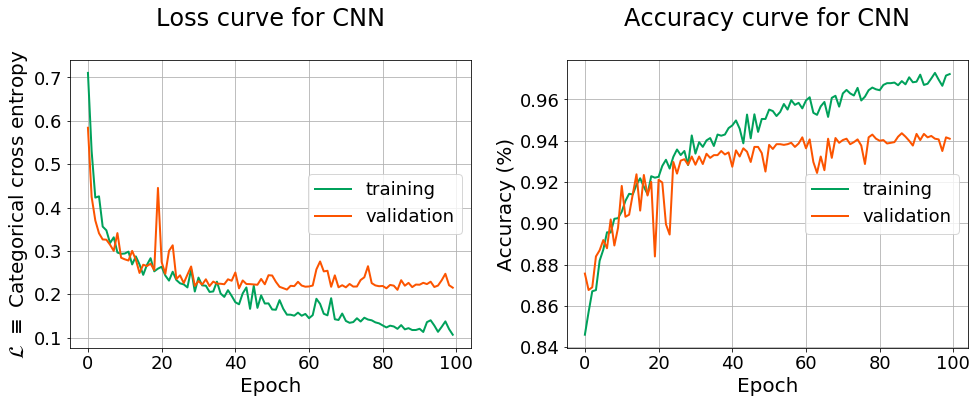

In [135]:
# logs the history of the run
history = model_history.history

# plots the history
fig, ax = plt.subplots(1,2, figsize=(14,6))
labels = ['training', 'validation']
loss_Accuracy = ['loss', 'val_loss', 'acc', 'val_acc']

plotLoss(ax[0], loss_Accuracy, labels)
plotAccuracy(ax[1], loss_Accuracy, labels)
 
fig.tight_layout()

## 5. Evaluate the result on the testing data set

Once we have trained the model to make predictions on the data, we evaluate it's performance on the test data set.

In [33]:
def saveModel(history, save_model_dir):
    """
    Function to save the model and it's history
    """
    model.save(save_model_dir+'.h5')
    
    with open(save_model_dir+'_history.pkl', 'wb') as filehandler:
        pickle.dump(history, filehandler)
    print('\nModel saved')
    return

In [40]:
# predictions made on the test data set, computes the confusion matrix

score = model.evaluate(X_test, Y_test,verbose=2)
print('\nLoss = %.2f percent, Accuracy = %.2f percent'%(score[0]*100, score[1]*100))

saveModel(history, save_model_dir)


Loss = 21.52 percent, Accuracy = 94.10 percent

Model saved


### 5.1 Computes the confusion matrix

It is a table that describes the performance of the classifier when compared to the test set data. 

In [122]:
def computeConfusionMatrix(model, X_test, Y_test):
    """
    Function prints the confusion matrix for the trained classifier/model
    @param model :: trained model
    @param X,Y_test :: array containing the X,Y test data sets
    """
    # need to recover the Y_pred from the one-hot encoded array
    X_pred = model.predict(X_test)
    Y_pred = np.argmax(X_pred, axis=1)
    
    # calculates the matrix by comparison
    confusion_mat = confusion_matrix(Y_test.argmax(axis=1), Y_pred)
    normalization = np.sum(confusion_mat, axis=1, keepdims=True)
    
    confusion_mat = confusion_mat/normalization
    print(confusion_mat)
    return confusion_mat

In [123]:
confusion_mat = computeConfusionMatrix(model, X_test, Y_test)

[[0.89655172 0.0795756  0.02387268]
 [0.02625062 0.96731055 0.00643883]
 [0.04545455 0.09504132 0.85950413]]
